# Fake News Classification

A dataset is provided containing different news articles.

We want to build a  model that can classify if a given article is considered fake or not. We will use a subset of the data for training and the remaining for testing our model.

## Outline

We separate the project in 3 steps:

**Data Loading and Processing:** Load the data and analyze it to obtain an accurate picture of it, its features, its values (and whether they are incomplete or wrong), its data types among others. We also do the required processing.

**Feature Engineering / Modeling:** Once we have the data, we create some features and then the modeling stage begins, we set multiple baselines making use of different models, we will hopefully produce a model that fits our expectations of performance. Once we have that model, a process of tuning it to the training data would be performed.

**Results and Conclusions:** Finally, with our tuned model, we  predict against the test set, and finally, outline our conclusions.

In [1]:
import re
import eli5
import spacy
import nltk as nl
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from nltk.stem.snowball import SnowballStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scikitplot.metrics import plot_confusion_matrix
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score as metric_scorer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
nl.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alejandro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Setting Key Values

The following values are used throught the code, this cell gives a central source where they can be managed.

In [2]:
SEED = 1

## Data Loading and Processing

Here we load the necessary data for training and testing, review its types and print its first rows.

In [3]:
train = pd.read_csv("fake_or_real_news_training.csv")
test = pd.read_csv("fake_or_real_news_test.csv")

### Data Types

In [4]:
train.dtypes

ID        int64
title    object
text     object
label    object
X1       object
X2       object
dtype: object

### First Rows of the Data

In [5]:
train.head()

,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN


### Sample News

In [6]:
train.iloc[2,2]

'U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sunday’s unity march against terrorism.\n\nKerry said he expects to arrive in Paris Thursday evening, as he heads home after a week abroad. He said he will fly to France at the conclusion of a series of meetings scheduled for Thursday in Sofia, Bulgaria. He plans to meet the next day with Foreign Minister Laurent Fabius and President Francois Hollande, then return to Washington.\n\nThe visit by Kerry, who has family and childhood ties to the country and speaks fluent French, could address some of the criticism that the United States snubbed France in its darkest hour in many years.\n\nThe French press on Monday was filled with questions about why neither President Obama nor Kerry attended Sunday’s march, as about 40 leaders of other nations did. Obama was said to have stayed away because his own security needs can be taxing on a country, 

### Data Cleaning
Since some rows have information spread accross different columns, we perform the required transformations in order to obtain the final text in a single column.

#### X1 Column

In [7]:
shifted_X1 = train.loc[(train['X1'] == 'REAL') | (train['X1'] == 'FAKE')]
fixed_X1 = pd.DataFrame(shifted_X1['title'].map(str) + ' ' + shifted_X1['text'].map(str) + ' ' + shifted_X1['label'].map(str), columns=["concat"])
fixed_X1['label'] = shifted_X1["X1"]
fixed_X1.head()

,concat,label
192,Election Day: No Legal Pot In Ohio Democrats ...,REAL
308,Who rode it best? Jesse Jackson mounts up to f...,FAKE
382,Black Hawk crashes off Florida human remains ...,REAL
660,Afghanistan: 19 die in air attacks on hospital...,REAL
889,Al Qaeda rep says group directed Paris magazin...,REAL


#### X2 Column

In [8]:
shifted_X2 = train.loc[(train['X2'] == 'REAL') | (train['X2'] == 'FAKE')]
fixed_X2 = pd.DataFrame(shifted_X2['title'] + ' ' + shifted_X2['text'].map(str) + ' ' + shifted_X2['label'].map(str) + ' ' + shifted_X2['X1'].map(str), columns = ['concat'])
fixed_X2['label'] = shifted_X2["X2"]
fixed_X2.head()

,concat,label
2184,Planned Parenthood’s lobbying effort pay rais...,REAL
3537,Chart Of The Day: Since 2009—–Recovery For The...,FAKE


### Label Column

In [9]:
labeled = train.loc[(train['label'] == 'REAL') | (train['label'] == 'FAKE')]
fixed_labeled = pd.DataFrame(labeled['title'].map(str) + ' ' + labeled['text'].map(str), columns = ['concat'])
fixed_labeled['label'] = labeled["label"]
fixed_labeled.head()

,concat,label
0,You Can Smell Hillary’s Fear Daniel Greenfield...,FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,FAKE
2,Kerry to go to Paris in gesture of sympathy U....,REAL
3,Bernie supporters on Twitter erupt in anger ag...,FAKE
4,The Battle of New York: Why This Primary Matte...,REAL


### Concatenated Train Set

In [10]:
train_cc = pd.concat([fixed_X1, fixed_X2, fixed_labeled], axis=0)
train_cc["concat"] = train_cc["concat"]
train_cc["title"] = train["title"]
train_cc.head()

,concat,label,title
192,Election Day: No Legal Pot In Ohio Democrats ...,REAL,Election Day: No Legal Pot In Ohio
308,Who rode it best? Jesse Jackson mounts up to f...,FAKE,Who rode it best? Jesse Jackson mounts up to f...
382,Black Hawk crashes off Florida human remains ...,REAL,Black Hawk crashes off Florida
660,Afghanistan: 19 die in air attacks on hospital...,REAL,Afghanistan: 19 die in air attacks on hospital
889,Al Qaeda rep says group directed Paris magazin...,REAL,Al Qaeda rep says group directed Paris magazin...


### Concatenated Test Set

In [11]:
test_cc = pd.DataFrame(test['title'].map(str) + ' ' + test['text'].map(str), columns = ['concat'])
test_cc["concat"] = test_cc["concat"]
test_cc["title"] = test["title"]
test_cc['ID'] = test["ID"]
test_cc.head()

,concat,title,ID
0,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise——-Back To 1992 ...,10498
1,Why The Obamacare Doomsday Cult Can't Admit It...,Why The Obamacare Doomsday Cult Can't Admit It...,2439
2,"Sanders, Cruz resist pressure after NY losses,...","Sanders, Cruz resist pressure after NY losses,...",864
3,Surviving escaped prisoner likely fatigued and...,Surviving escaped prisoner likely fatigued and...,4128
4,Clinton and Sanders neck and neck in Californi...,Clinton and Sanders neck and neck in Californi...,662


### Check target variable balance
We review the distribution of values in the target variable.

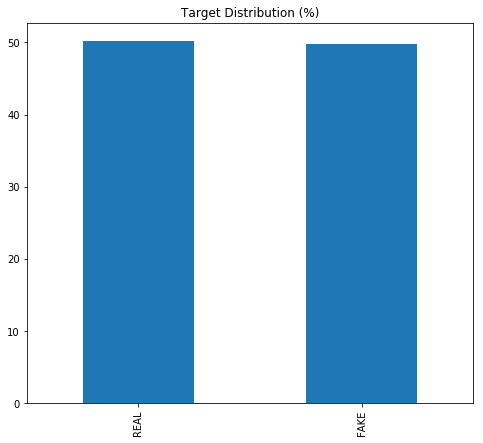

In [12]:
plt.figure(figsize=(8, 7))
target_count = (train_cc["label"].value_counts() / len(train_cc)) * 100
target_count.plot(kind="bar", title="Target Distribution (%)")

The distribution is perfect, therefore no resampling is needed.

## Tokenizing data
We convert the different articles to a matrix of token counts

In [13]:
count_vect = CountVectorizer()
base_train = count_vect.fit_transform(train_cc.concat)
print(base_train.shape)

(3999, 55777)


## Normalized TF/TF-IDF Representation

Now we transform the matrix of token counts to a normalized tf or tf-idf representation, where tf represents term frequency and tf-idf represents the frequency times the inverse document frequency, that way the importance/scale of certain repeated tokens throughout the text is reduced.

In [14]:
tfidf_transformer = TfidfTransformer()
base_train = tfidf_transformer.fit_transform(base_train)
print(base_train.shape)

(3999, 55777)


### 2 Component PCA on TF-IDF Representation
Now we will reduce dimensionality on the TF-IDF Representation to 2 components to see how they differ.

In [50]:
pcaed = TruncatedSVD(n_components=2).fit_transform(base_train)
pcaed = pd.concat([pd.DataFrame(pcaed), train_cc.label], axis=1)
pcaed.head()

,0,1,label
0,0.508925,-0.020089,FAKE
1,0.188548,0.012078,FAKE
2,0.448489,-0.125087,REAL
3,0.479546,-0.141641,FAKE
4,0.525477,-0.162061,REAL


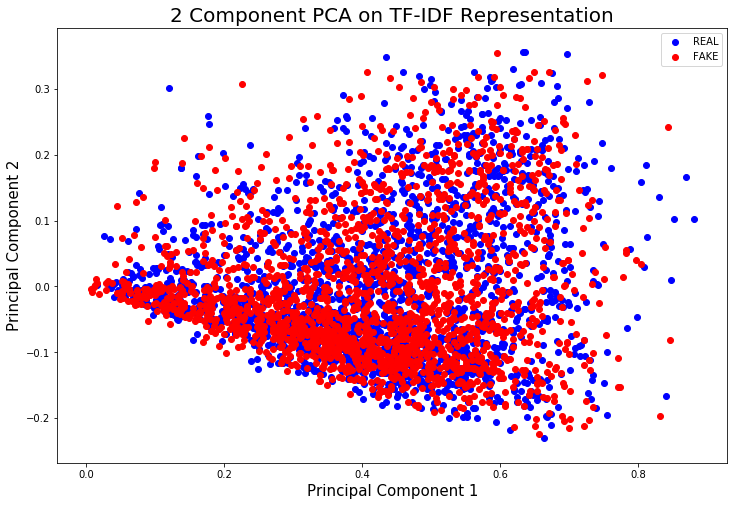

In [55]:
pctrue=pcaed[pcaed["label"]=="REAL"]
pcfake=pcaed[pcaed["label"]=="FAKE"]
plt.figure(figsize = (12,8))
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('2 Component PCA on TF-IDF Representation', fontsize = 20)
plt.scatter(pctrue[0], pctrue[1], color="blue")
plt.scatter(pcfake[0], pcfake[1], color="red")
plt.legend(["REAL", "FAKE"])

We can see that they are very similar and that there is no clear distinction between the two.

## Feature Engineering / Modeling

## Baseline

In order to test the performance of our feature engineering steps, we will create several initial baseline models, that way we will see how our efforts increase the models predictive power.

### Train Function
Here we define the train function which will be used with the different models, it performs a cross validation score on 80% of the training data and a final validation on the remaining 20%.

In [56]:
def train(X, y, model, grid = None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
    
    if grid:
        model = RandomizedSearchCV(model, grid, cv=5, n_iter=10, refit=True, return_train_score=False, error_score=0.0, n_jobs=-1, random_state=SEED)
        model.fit(X_train, y_train)
        scores = model.cv_results_["mean_test_score"]
    else:
        scores = cross_val_score(model, X_train, y_train, cv=5)
        model.fit(X_train, y_train)
        
    predictions = model.predict(X_test)

    print("Cross validation scores: \n" + str(scores))
    print("Classification Report: \n" + str(classification_report(y_test, predictions)))
    print("Accuracy: \n" + str(metric_scorer(y_test, predictions)))
    print("Confusion Matrix: \n")
    plot_confusion_matrix(y_test, predictions)
    
    return model

### Naive Bayes 

Cross validation scores: 
[0.725      0.721875   0.7546875  0.7015625  0.72143975]
Classification Report: 
              precision    recall  f1-score   support

        FAKE       0.98      0.54      0.70       421
        REAL       0.66      0.99      0.79       379

   micro avg       0.76      0.76      0.76       800
   macro avg       0.82      0.77      0.75       800
weighted avg       0.83      0.76      0.74       800

Accuracy: 
0.755
Confusion Matrix: 



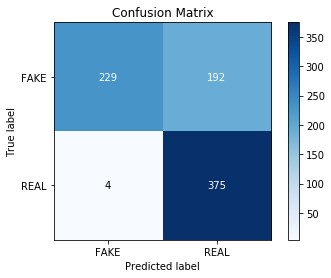

In [17]:
X = base_train
y = train_cc['label']
nb = train(X, y, MultinomialNB())

### Random Forest

Cross validation scores: 
[0.89375    0.8796875  0.8890625  0.8625     0.87636933]
Classification Report: 
              precision    recall  f1-score   support

        FAKE       0.87      0.92      0.90       421
        REAL       0.91      0.85      0.88       379

   micro avg       0.89      0.89      0.89       800
   macro avg       0.89      0.89      0.89       800
weighted avg       0.89      0.89      0.89       800

Accuracy: 
0.88875
Confusion Matrix: 



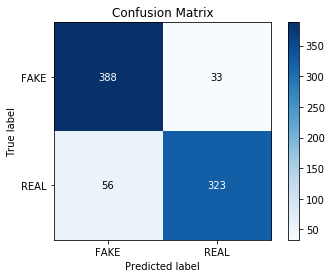

In [16]:
rf = train(X, y, RandomForestClassifier(n_estimators=100, random_state=SEED))

### Logistic Regression

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Cross validation scores: 
[0.8921875  0.8921875  0.89375    0.9046875  0.89514867]
Classification Report: 
              precision    recall  f1-score   support

        FAKE       0.91      0.93      0.92       421
        REAL       0.92      0.89      0.91       379

   micro avg       0.91      0.91      0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800

Accuracy: 
0.9125
Confusion Matrix: 



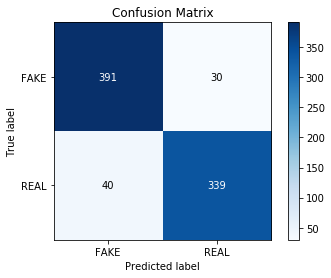

In [18]:
lrg = train(X, y, LogisticRegression())

### Support Vector Machine

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Cross validation scores: 
[0.896875   0.9109375  0.8890625  0.90625    0.90140845]
Classification Report: 
              precision    recall  f1-score   support

        FAKE       0.88      0.95      0.92       421
        REAL       0.94      0.86      0.90       379

   micro avg       0.91      0.91      0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800

Accuracy: 
0.90875
Confusion Matrix: 



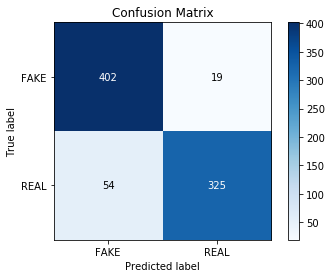

In [19]:
svm = train(X, y, SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=SEED))

### Passive Aggressive Classifier

Cross validation scores: 
[0.934375   0.946875   0.9296875  0.925      0.93114241]
Classification Report: 
              precision    recall  f1-score   support

        FAKE       0.93      0.94      0.93       421
        REAL       0.93      0.92      0.92       379

   micro avg       0.93      0.93      0.93       800
   macro avg       0.93      0.93      0.93       800
weighted avg       0.93      0.93      0.93       800

Accuracy: 
0.92875
Confusion Matrix: 



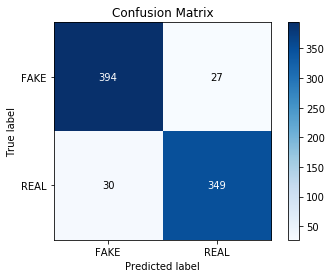

In [20]:
pac = train(X, y, PassiveAggressiveClassifier(max_iter=1000, random_state=SEED, tol=1e-3))

We can see that the Passive Aggressive classifier was the best performing one during our baseline.

## Feature Engineering

### Original Data

In [21]:
train_cc.head()

,concat,label,title
192,Election Day: No Legal Pot In Ohio Democrats ...,REAL,Election Day: No Legal Pot In Ohio
308,Who rode it best? Jesse Jackson mounts up to f...,FAKE,Who rode it best? Jesse Jackson mounts up to f...
382,Black Hawk crashes off Florida human remains ...,REAL,Black Hawk crashes off Florida
660,Afghanistan: 19 die in air attacks on hospital...,REAL,Afghanistan: 19 die in air attacks on hospital
889,Al Qaeda rep says group directed Paris magazin...,REAL,Al Qaeda rep says group directed Paris magazin...


### Stemming
Here we will stem the news text with two different stemmers (Porter and Snowball) and see how the scores differ. Overall, we perform the following transformations:

- Stemming of the words

- Removing punctuation, stop words and other characters

- Convert to Lower case and split string into words (tokenization)

In [22]:
stem_train = train_cc.copy()
words = stopwords.words("english")
#stemmer = PorterStemmer()
stemmer = SnowballStemmer(language='english')
stem_train['concat'] = stem_train['concat'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
stem_train.head()                

,concat,label,title
192,elect day no legal pot in ohio democrat lose i...,REAL,Election Day: No Legal Pot In Ohio
308,who rode best jess jackson mount fight pipelin...,FAKE,Who rode it best? Jesse Jackson mounts up to f...
382,black hawk crash florida human remain found cn...,REAL,Black Hawk crashes off Florida
660,afghanistan die air attack hospit u s investig...,REAL,Afghanistan: 19 die in air attacks on hospital
889,al qaeda rep say group direct pari magazin att...,REAL,Al Qaeda rep says group directed Paris magazin...


Cross validation scores: 
[0.9296875  0.9296875  0.9375     0.9421875  0.94209703]
Classification Report: 
              precision    recall  f1-score   support

        FAKE       0.95      0.95      0.95       421
        REAL       0.94      0.95      0.95       379

   micro avg       0.95      0.95      0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800

Accuracy: 
0.94875
Confusion Matrix: 



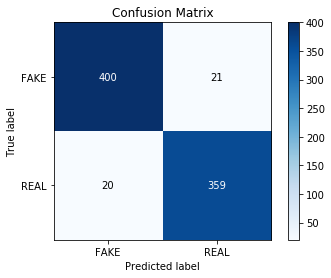

In [23]:
stem_train = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2)).fit_transform(stem_train["concat"])
X = stem_train
y = train_cc['label']
pac = train(X, y, PassiveAggressiveClassifier(max_iter=1000, random_state=SEED, tol=1e-3))

The Snowball Stemmer performed much better than the Porter Stemmer in our tests.

Stemming is closely related to lemmatisation. The difference is that a stemmer operates on a single word without knowledge of the context, and therefore cannot discriminate between words which have different meanings depending on part of speech. However, stemmers are typically easier to implement and run faster, and the reduced accuracy may not matter for some applications.

## Lemmatizing and POS Tagging with Spacy

Using Spacy we will do the following transformations:

- Lemmatization of the words

- POS Tagging of the words

- Removing punctuation, stop words and other characters

- Convert to Lower case and split string into words (tokenization)

- We remove words with a frequency of less than 0.01% or with more than 0.99%

Here is a sample of the lemmatization and tagging:

In [57]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat"])
doc = nlp(train_cc['concat'][3])
print(doc.text[:50])
print('----------------------------------------------------')
for token in doc[:5]:
    print(f'Token: {token.text}, Lemma: {token.lemma_}, POS: {token.pos_}')

Bernie supporters on Twitter erupt in anger agains
----------------------------------------------------
Token: Bernie, Lemma: Bernie, POS: PROPN
Token: supporters, Lemma: supporter, POS: NOUN
Token: on, Lemma: on, POS: ADP
Token: Twitter, Lemma: Twitter, POS: PROPN
Token: erupt, Lemma: erupt, POS: NOUN


### Defining our own Tokenizer

The removal of punctuation, stop words and digits decreased the models performance, therefore it is commented.

We Tested different "ngram_range" configurations with (1, 2) being the optimal solution both on accuracy and running time.

In [58]:
def tokenizer(text):
    return [token.lemma_.lower().strip() + token.pos_ for token in nlp(text)]
#     if 
#         not token.is_stop and not nlp.vocab[token.lemma_].is_stop
#         and not token.is_punct
#         and not token.is_digit
#     ]

vect = TfidfVectorizer(analyzer = 'word', max_df=0.99, min_df=0.01, ngram_range=(1,2), tokenizer=tokenizer)

### Testing with tokenized concatenated text and title

In [59]:
vectorized = vect.fit_transform(train_cc["concat"])
vectorized.shape

(3999, 13952)

Cross validation scores: 
[0.9484375  0.9625     0.9484375  0.946875   0.95305164]
Classification Report: 
              precision    recall  f1-score   support

        FAKE       0.96      0.97      0.96       421
        REAL       0.96      0.95      0.96       379

   micro avg       0.96      0.96      0.96       800
   macro avg       0.96      0.96      0.96       800
weighted avg       0.96      0.96      0.96       800

Accuracy: 
0.96
Confusion Matrix: 



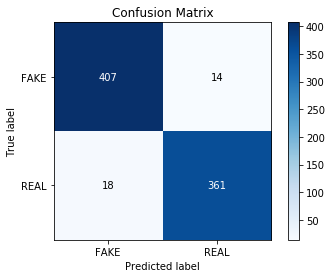

In [60]:
X = vectorized
y = train_cc['label']
pac = train(X, y, PassiveAggressiveClassifier(max_iter=1000, random_state=SEED, tol=1e-3))

### Testing with tokenized title

In [28]:
vect_title = vect.fit_transform(train_cc["title"])
vect_title.shape

(3999, 169)

Cross validation scores: 
[0.6671875  0.690625   0.709375   0.7390625  0.72300469]
Classification Report: 
              precision    recall  f1-score   support

        FAKE       0.72      0.74      0.73       421
        REAL       0.70      0.68      0.69       379

   micro avg       0.71      0.71      0.71       800
   macro avg       0.71      0.71      0.71       800
weighted avg       0.71      0.71      0.71       800

Accuracy: 
0.70875
Confusion Matrix: 



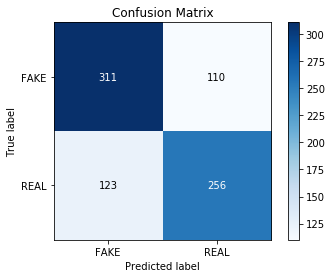

In [29]:
X = vect_title
y = train_cc['label']
pac = train(X, y, PassiveAggressiveClassifier(max_iter=1000, random_state=SEED, tol=1e-3))

### Testing with a combination of tokenized title and concatenated text and title

In [30]:
vectfinal = hstack([vectorized, vect_title])
vectfinal.shape

(3999, 14121)

Cross validation scores: 
[0.9359375  0.95625    0.940625   0.925      0.94522692]
Classification Report: 
              precision    recall  f1-score   support

        FAKE       0.94      0.95      0.94       421
        REAL       0.94      0.93      0.94       379

   micro avg       0.94      0.94      0.94       800
   macro avg       0.94      0.94      0.94       800
weighted avg       0.94      0.94      0.94       800

Accuracy: 
0.94
Confusion Matrix: 



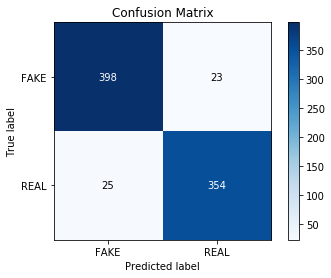

In [31]:
X = vectfinal
y = train_cc['label']
pac = train(X, y, PassiveAggressiveClassifier(max_iter=1000, random_state=SEED, tol=1e-3))

The best performing one was simply with a tokenized concatenated text and title version.

## Hyperparameter Tuning

Now that we have the best performing model which is a Passive Agressive Classifier with lemmatization and POS tagging of the concatenated text and title, we will do a 5 fold cross validated randomized grid search over it to get the best parameters for the model.

Cross validation scores: 
[0.94873398 0.94873398 0.94810878 0.94904658 0.94873398 0.94935917
 0.94873398 0.94810878 0.94748359 0.94810878]
Classification Report: 
              precision    recall  f1-score   support

        FAKE       0.95      0.96      0.96       421
        REAL       0.96      0.95      0.95       379

   micro avg       0.95      0.95      0.95       800
   macro avg       0.96      0.95      0.95       800
weighted avg       0.96      0.95      0.95       800

Accuracy: 
0.955
Confusion Matrix: 



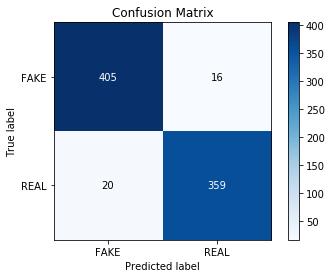

In [54]:
X = train_cc['concat']
y = train_cc['label']

grid = {
    "pac__C": [1.0, 10.0, 100.0],
    "pac__tol": [1e-2, 1e-3, 1e-4],
    "pac__max_iter": [1000, 2000, 3000],
}

pipeline = Pipeline([
    ('vect', vect),
    ('pac', PassiveAggressiveClassifier(max_iter=1000, C=1.0, random_state=SEED, tol=1e-3, n_jobs=-1))
])

pipeline = train(X, y, pipeline, grid)

In [71]:
pipeline.best_params_

{'pac__tol': 0.001, 'pac__max_iter': 1000, 'pac__C': 10.0}

## Final Pipeline
We can see that the accuracy decreased from the hyperpaarameter tuning, this may be due to overfitting of the data, therefore we will stick to our initial model and create a final pipeline to perform predictionss on the test data.

In [76]:
final_pipe = Pipeline([
    ('vect', vect),
    ('pac', PassiveAggressiveClassifier(max_iter=1000, random_state=SEED, tol=1e-3))
])

X = train_cc['concat']
y = train_cc['label']

final_pipe.fit(X, y)

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.99, max_features=None, min_df=0.01,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=Tr...te=1, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False))])

## Explaining the model
Here we see the associated weights to the different tokens and wether they are positive or negative with regards to classifying a news as REAL.

It seems like proper punctuation ('s in the end of words, use of commas, etc) really help the model to see if it is a real or fake news, also having many exclamation signs does the inverse.

In [99]:
eli5.show_weights(final_pipe, top=30, target_names=train_cc.label)

Weight?,Feature
+5.499,SPACE “PROPN
+5.070,'sPART
+3.675,--PUNCT
+2.696,—PUNCT
+2.562,",PUNCT SPACE"
+2.475,.PUNCT butCCONJ
+2.419,thatDET
+2.315,cruzNOUN
+2.293,candidateNOUN
+2.290,wilsonNOUN


### Explained prediction on one news article
Usign the same library we will attempt to understand how a specific news item from the test set is predicted.

In [109]:
test_cc.concat[1]

'Why The Obamacare Doomsday Cult Can\'t Admit It\'s Wrong But when Congress debated and passed the Patient Protection and Affordable Care Act in 2009 and 2010, opponents were nearly unified in offering grim Keech-like predictions. With Obamacare now in full effect, and the economy on a decided upswing, the dour prognostications are starting to look like Keech\'s flying saucers. At least if you believe the data. A look at Festinger\'s theories, though, can explain why that won\'t matter, and why Americans can expect a continued drumbeat of doom, even as the prophecies fail.\n\n“It certainly has not had the baleful effects the critics were predicting,” said Paul Van de Water, a senior fellow at the Center on Budget and Policy Priorities who supports the law, but never thought it would have much economic impact. “On balance it may be a modest plus, to the extent that it has contributed to the slowdown of growth in health care costs.”\n\nBut that\'s not how Capitol Hill’s gloomsday cult se

In [110]:
eli5.show_prediction(final_pipe.named_steps['pac'], test_cc.concat[1], vec=vect, top=30, target_names=train_cc.label)

It looks like the news article is REAL from the weights of the different tokens it has.

## Predictions on Test Set

Now with our final pipeline we perform preditions on the entire test set.

In [78]:
final_test = test_cc.copy()
final_test["predictions"] = final_pipe.predict(final_test["concat"])
final_test.columns = ["concat", "title", "News_id", "prediction"]
final_test[["News_id", "prediction"]].to_csv("predictions.csv", index=False)
final_test.head()

,concat,title,News_id,prediction
0,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise——-Back To 1992 ...,10498,FAKE
1,Why The Obamacare Doomsday Cult Can't Admit It...,Why The Obamacare Doomsday Cult Can't Admit It...,2439,REAL
2,"Sanders, Cruz resist pressure after NY losses,...","Sanders, Cruz resist pressure after NY losses,...",864,REAL
3,Surviving escaped prisoner likely fatigued and...,Surviving escaped prisoner likely fatigued and...,4128,REAL
4,Clinton and Sanders neck and neck in Californi...,Clinton and Sanders neck and neck in Californi...,662,REAL


# Conclusions

The classification report obtained from our final model on a 20% holdout of the data shows its accuracy, precision (how often the predictions are correct) and the recall (how many of the total observations in the set are correctly classified), also its f1-score (harmonic average of both). The weighted average for all of them stands at 96% which means that it can classify which articles are fake with great efficacy.

This information is extremely useful to multiple actors, including social networks and end consumers since it can help them differentiate between real and fake stories, which often lead to skewed views of current world events.